# Inport Necessary Libralies

In [20]:
import praw
import configparser
import pandas as pd
import re
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import matplotlib.pyplot as plt
import seaborn as sns

# Set up configuration

In [21]:
# Set up search conditions 

#Define the broad search term (replaces the 'search_phrases' list)
SEARCH_TERM = '(Cybertruck Problems OR Cybertruck Issues OR Cybertruck Rust)'

# Set up search conditions (re-stating for clarity, assuming they are defined earlier)
SUBREDDITS = ['teslamotors', 'RealTesla', 'cars', 'technology']
POST_LIMIT = 1000

# Read config.ini
config = configparser.ConfigParser()
config.read('config.ini')

# Initialise Praw Client
try:
    # user authentication
    reddit = praw.Reddit(
        client_id=config['reddit']['client_id'],
        client_secret=config['reddit']['client_secret'],
        user_agent=config['reddit']['user_agent'],
        username=config['reddit']['username'],
        password=config['reddit']['password']
    )
    # Ensure the log in successful.
    print(f"PRAW client initialized. Logged in as: {reddit.user.me().name}")

except KeyError as e:
    print(f"FATAL ERROR: Missing Reddit credential in config.ini. Check key: {e}")
    exit()
except Exception as e:
    print(f"An error occurred during PRAW initialization or login: {e}")
    exit()

PRAW client initialized. Logged in as: Afraid-Medicine4769


# Retrive and Collect Submissions

In [22]:
# Define the flexible search terms for Python to check
search_phrases = ['cybertruck', 'tesla truck', 'musk truck', 'stainless steel rust']

collected_posts = []

print(f"\n--- Starting data collection across {len(SUBREDDITS)} subreddits ---")

for subreddit_name in SUBREDDITS:
    print(f"Searching r/{subreddit_name}...")
    try:
        subreddit = reddit.subreddit(subreddit_name)
        
        # Keep .new() but for smaller subreddits, it should be faster and more accurate
        for submission in subreddit.new(limit=POST_LIMIT):
            
            # Combine the title and text to search for the term, and convert to lowercase
            full_content = (submission.title + ' ' + submission.selftext).lower()
            
            # Filter the posts yourself in Python for any of the flexible phrases
            if any(phrase in full_content for phrase in search_phrases):
                collected_posts.append({
                    'id': submission.id,
                    'subreddit': subreddit_name,
                    'title': submission.title,
                    'text': submission.selftext,
                    'score': submission.score,
                    'num_comments': submission.num_comments,
                    'created_utc': submission.created_utc,
                    'url': submission.url
                })
            
    except Exception as e:
        print(f"Skipping r/{subreddit_name} due to an error: {e}")
        continue # Move to the next subreddit

print(f"\nData Collection Complete. Total submissions collected: {len(collected_posts)}")


--- Starting data collection across 4 subreddits ---
Searching r/teslamotors...
Searching r/RealTesla...
Searching r/cars...
Searching r/technology...

Data Collection Complete. Total submissions collected: 222


In [23]:
# CONVERT TO DATAFRAME AND DISPLAY SAMPLE
if collected_posts:
    df = pd.DataFrame(collected_posts)
    
    # Convert timestamp
    df['created_at'] = pd.to_datetime(df['created_utc'], unit='s')
    
    print("\n--- Sample of Retrieved Data (First 5 Rows) ---")
    print(df[['subreddit', 'title', 'score', 'num_comments', 'created_at']].head())
    
    # ----------------------------------------------------
    # PHASE 2: DATA CLEANING AND SENTIMENT ANALYSIS
    # ----------------------------------------------------
    
    print("\n--- Starting Data Cleaning and Sentiment Analysis ---")
    
    def clean_text(text):
        """Removes links, special characters, and converts to lowercase."""
        # Remove URLs
        text = re.sub(r'http\S+|www.\S+', '', str(text))
        # Remove anything that isn't a word character or whitespace
        text = re.sub(r'[^\w\s]', '', text)
        # Convert to lowercase
        return text.lower()

    # Apply cleaning function to both title and text columns
    df['cleaned_title'] = df['title'].apply(clean_text)
    df['cleaned_text'] = df['text'].apply(clean_text)

    # Initialize VADER sentiment analyzer
    analyzer = SentimentIntensityAnalyzer()

    def analyze_sentiment(text):
        """Returns the VADER compound score for a given text."""
        if not text.strip():
            return 0.0 # Return neutral for empty text
        vs = analyzer.polarity_scores(text)
        return vs['compound']

    # Apply sentiment analysis to the cleaned content
    df['title_sentiment'] = df['cleaned_title'].apply(analyze_sentiment)
    df['text_sentiment'] = df['cleaned_text'].apply(analyze_sentiment)
    
    # Create a composite sentiment score (Weighted average of title and text)
    # We weight the title slightly higher as it's the main hook/opinion
    df['composite_sentiment'] = (df['title_sentiment'] * 0.6) + (df['text_sentiment'] * 0.4)
    
    # Classify the sentiment
    def classify_sentiment(score):
        if score >= 0.05:
            return 'Positive'
        elif score <= -0.05:
            return 'Negative'
        else:
            return 'Neutral'

    df['sentiment_label'] = df['composite_sentiment'].apply(classify_sentiment)

    print("\n--- Sentiment Analysis Complete (Sample) ---")
    print(df[['subreddit', 'title', 'sentiment_label', 'composite_sentiment']].head())
    
else:
    print("\nNo posts were found matching the search criteria.")


--- Sample of Retrieved Data (First 5 Rows) ---
     subreddit                                              title  score  \
0  teslamotors  v14 comments from Tesla employees, cybertruck ...    349   
1  teslamotors  2025 Tesla Cybertruck ratings Good versus Ford...     88   
2  teslamotors         Police vehicles in my city are Cybertrucks    838   
3  teslamotors  Cybertruck hit a peak rate of 483 kW at the ne...    181   
4  teslamotors                     Germany can’t have cybertrucks    970   

   num_comments          created_at  
0           128 2025-10-07 21:10:07  
1            16 2025-10-07 16:06:03  
2            81 2025-10-04 22:26:23  
3            44 2025-09-30 13:21:56  
4           275 2025-09-29 14:38:50  

--- Starting Data Cleaning and Sentiment Analysis ---

--- Sentiment Analysis Complete (Sample) ---
     subreddit                                              title  \
0  teslamotors  v14 comments from Tesla employees, cybertruck ...   
1  teslamotors  2025 Tesla 


--- Starting Data Visualization ---


/var/folders/jc/32xy7t714y5clrhjsh4zr3d40000gn/T/ipykernel_1252/1834509505.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='sentiment_label', data=df, order=['Negative', 'Neutral', 'Positive'], palette=['#E74C3C', '#F39C12', '#2ECC71'])


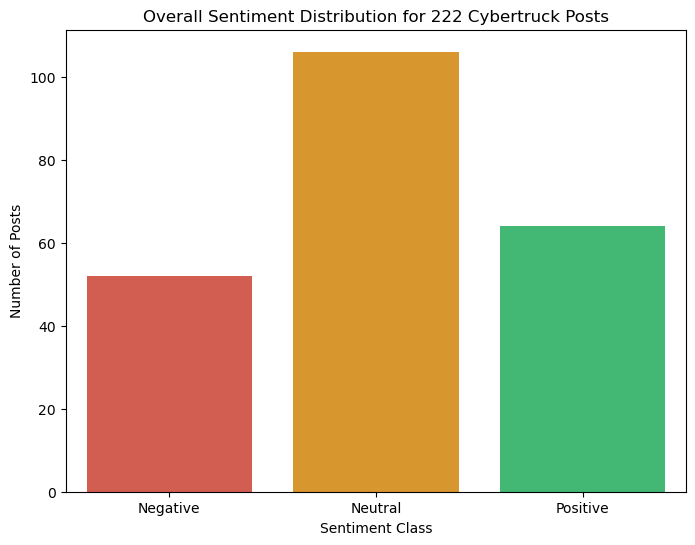

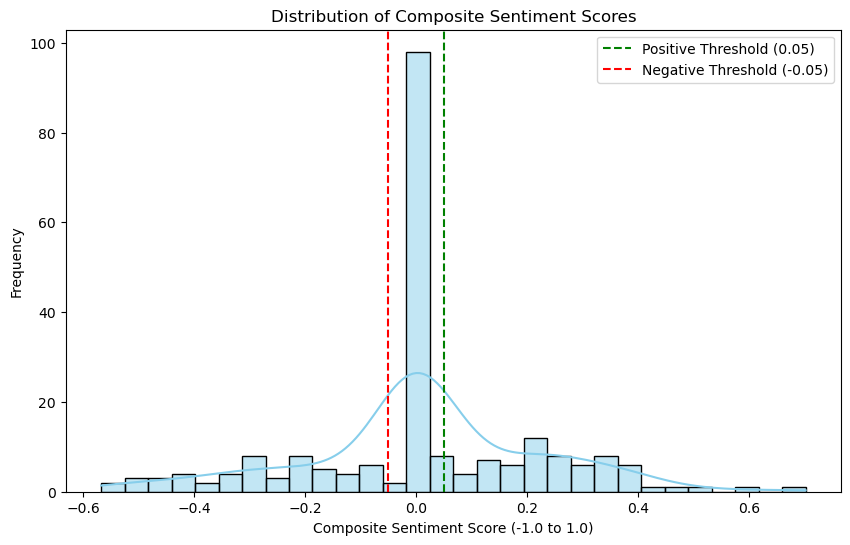

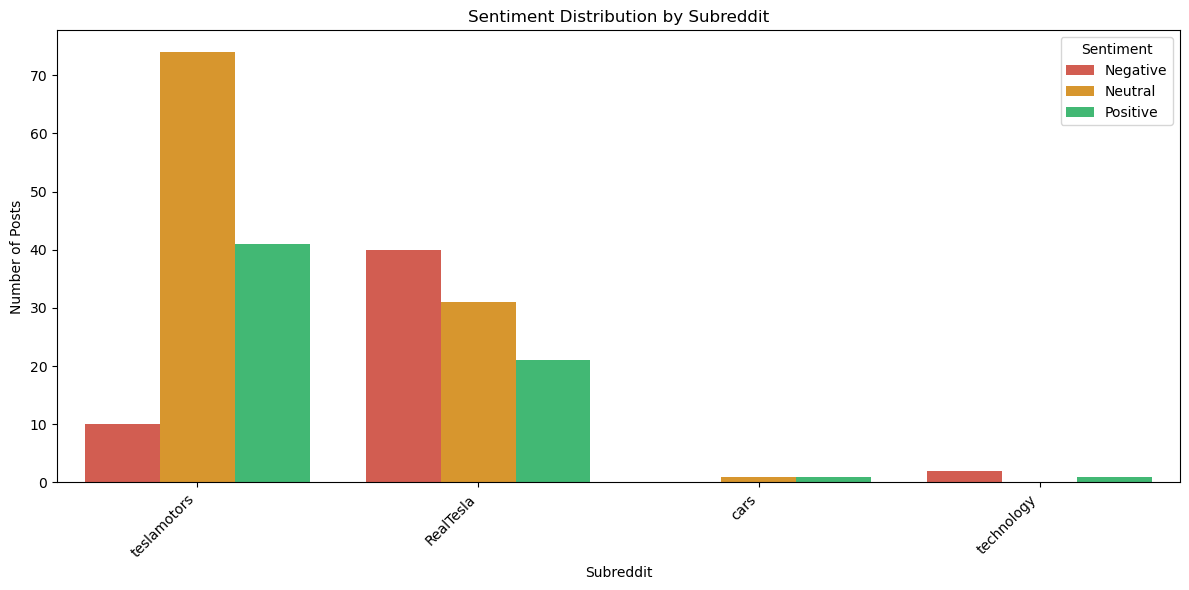


--- Key Findings Report ---

Overall Sentiment Breakdown:
sentiment_label
Neutral     47.7%
Positive    28.8%
Negative    23.4%
Name: proportion, dtype: object

Top 5 Most Upvoted Posts (Related to Cybertruck Issues):
  - Subreddit: r/technology
    Title: Teen was burned alive in malfunctioning Tesla Cybertruck, lawsuit clai...
    Score: 21594, Comments: 1473
    Sentiment: Positive (0.107)

  - Subreddit: r/RealTesla
    Title: Elon’s Edsel: Tesla Cybertruck is the auto industry’s biggest flop in ...
    Score: 9844, Comments: 434
    Sentiment: Negative (-0.204)

  - Subreddit: r/RealTesla
    Title: Tesla is sitting on $200 million worth of Cybertruck inventory...
    Score: 6085, Comments: 538
    Sentiment: Positive (0.136)

  - Subreddit: r/RealTesla
    Title: Cybertruck Sales Are So Bad That We Gasped...
    Score: 3097, Comments: 354
    Sentiment: Negative (-0.402)

  - Subreddit: r/RealTesla
    Title: Forbes: Tesla’s Very Existence Is On The Line As 10,000 Cybertrucks Re

In [24]:
# Assuming your DataFrame is named 'df' from the previous step

print("\n--- Starting Data Visualization ---")

# 1. Overall Sentiment Distribution Bar Chart
plt.figure(figsize=(8, 6))
sns.countplot(x='sentiment_label', data=df, order=['Negative', 'Neutral', 'Positive'], palette=['#E74C3C', '#F39C12', '#2ECC71'])
plt.title(f'Overall Sentiment Distribution for {len(df)} Cybertruck Posts')
plt.xlabel('Sentiment Class')
plt.ylabel('Number of Posts')
plt.show()

# 2. Distribution of Composite Sentiment Scores (Histogram)
plt.figure(figsize=(10, 6))
sns.histplot(df['composite_sentiment'], bins=30, kde=True, color='skyblue')
plt.title('Distribution of Composite Sentiment Scores')
plt.xlabel('Composite Sentiment Score (-1.0 to 1.0)')
plt.ylabel('Frequency')
plt.axvline(x=0.05, color='green', linestyle='--', label='Positive Threshold (0.05)')
plt.axvline(x=-0.05, color='red', linestyle='--', label='Negative Threshold (-0.05)')
plt.legend()
plt.show()

# 3. Sentiment Distribution by Subreddit (Count Plot)
plt.figure(figsize=(12, 6))
sns.countplot(x='subreddit', hue='sentiment_label', data=df, 
              hue_order=['Negative', 'Neutral', 'Positive'],
              palette=['#E74C3C', '#F39C12', '#2ECC71'])
plt.title('Sentiment Distribution by Subreddit')
plt.xlabel('Subreddit')
plt.ylabel('Number of Posts')
plt.legend(title='Sentiment')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


# ----------------------------------------------------
# PHASE 3: REPORTING KEY METRICS
# ----------------------------------------------------

print("\n--- Key Findings Report ---")

# Calculate overall percentages
sentiment_counts = df['sentiment_label'].value_counts(normalize=True).mul(100).round(1).astype(str) + '%'
print("\nOverall Sentiment Breakdown:")
print(sentiment_counts)

# Get top 5 most engaged posts (highest score) and their sentiment
top_posts = df.sort_values(by='score', ascending=False).head(5)
print("\nTop 5 Most Upvoted Posts (Related to Cybertruck Issues):")
for index, row in top_posts.iterrows():
    print(f"  - Subreddit: r/{row['subreddit']}")
    print(f"    Title: {row['title'][:70]}...")
    print(f"    Score: {row['score']}, Comments: {row['num_comments']}")
    print(f"    Sentiment: {row['sentiment_label']} ({row['composite_sentiment']:.3f})\n")